In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
path = '/content/gdrive/MyDrive/Dataset/'
image_path = os.path.join(path, './image/')
mask_path = os.path.join(path, './Mask2/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
image_list.sort()
mask_list = [mask_path+i for i in mask_list]
mask_list.sort()

In [4]:
image_list[10]

'/content/gdrive/MyDrive/Dataset/./image/ASHOURI^MAHDI_723643_48907_11_20.png'

In [5]:
mask_list[10]

'/content/gdrive/MyDrive/Dataset/./Mask2/ASHOURI%5EMAHDI_723643_48907_11_20_Tumor_background.ome_result.png'

In [6]:
import tensorflow as tf
import os
import random
import numpy as np

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [7]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3



In [8]:
X_train = np.zeros((219, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((219, IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)

In [9]:
Y_train.shape

(219, 128, 128, 1)

In [10]:
print('Resizing training images ')
n=0
for i in image_list:
    img = imread(i)[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img  #Fill empty X_train with values from img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)
    n += 1

Resizing training images 


In [11]:
X_train.shape

(219, 128, 128, 3)

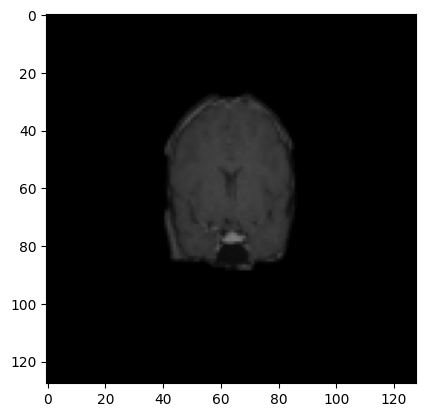

In [12]:
plt.imshow(X_train[120,:,:,:]);

In [13]:
print('Resizing masks.. ')
n=0
for i in mask_list:
    img = imread(i)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH,1), mode='constant', preserve_range=True)
    Y_train[n] = img  #Fill empty X_train with values from img
    n += 1

Resizing masks.. 


In [14]:
Y_train.shape

(219, 128, 128, 1)

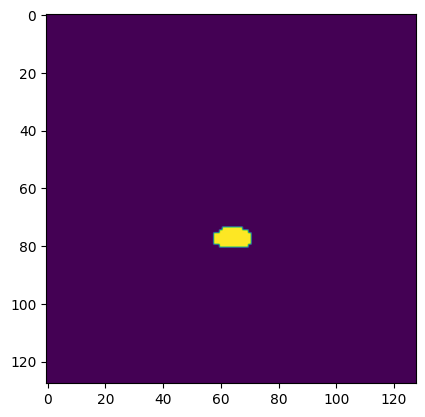

In [15]:
plt.imshow(np.squeeze(Y_train[120,:,:,:]))
plt.show()

In [16]:
import tensorflow.keras.metrics as metrics

In [17]:
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[metrics.Precision(),'accuracy'])
model.summary()

################################

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 128, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 16)   │            448 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 16)   │          2,320 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 16)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 32)     │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 32)     │          9,248 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 32)     │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 64)     │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 64)     │         36,928 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 128)    │              0 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        147,584 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 128)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)       

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor='precision', mode='max'),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='precision', mode='max')
]

results = model.fit(
    X_train, Y_train,
    batch_size=20,
    epochs=15,
    callbacks=callbacks
)


Epoch 1/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 54s 4s/step - accuracy: 0.9761 - loss: 0.5488 - precision: 0.0241
Epoch 2/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 77s 4s/step - accuracy: 0.9839 - loss: 0.2578 - precision: 0.0173
Epoch 3/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.9838 - loss: 0.1062 - precision: 0.0000e+00
Epoch 4/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9841 - loss: 0.0670 - precision: 0.0000e+00
Epoch 5/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - accuracy: 0.9842 - loss: 0.0589 - precision: 0.6278
Epoch 6/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.9834 - loss: 0.0505 - precision: 0.9938
Epoch 7/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 3s/step - accuracy: 0.9822 - loss: 0.0474 - precision: 0.8439
Epoch 8/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.9847 - loss: 0.0429 - precision: 0.8935
Epoch 9/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - accuracy: 0.9845 - loss: 0.0431 - precision: 0.8925
Epoch 10/15
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - acc

In [19]:
# Enable unsafe deserialization (not recommended)
import keras
keras.config.enable_unsafe_deserialization()

# Now you can load the model (still not recommended)
best_model = tf.keras.models.load_model(
    'best_model.keras',
    custom_objects={'Precision': tf.keras.metrics.Precision}
)

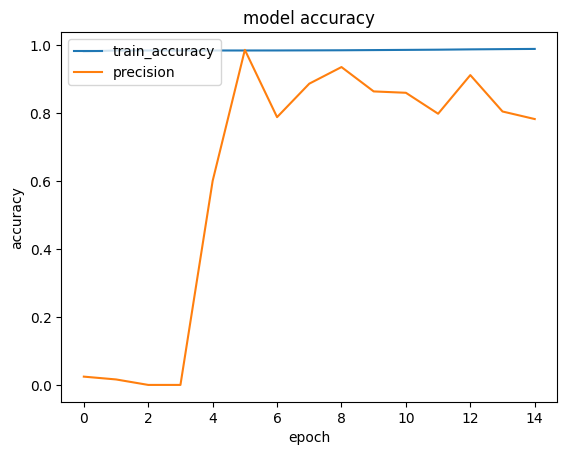

In [20]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['precision'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy',"precision"], loc='upper left')
plt.show()

In [21]:
idx = random.randint(0, 129)


train_predict = best_model.predict(X_train, verbose=1)
preds_train_t = (train_predict > 0.5).astype(bool)

7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step


In [22]:
train_predict.shape

(219, 128, 128, 1)

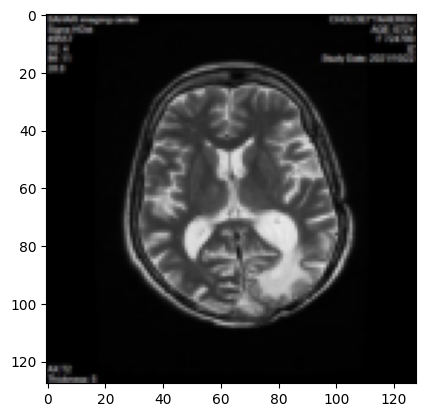

In [23]:
plt.imshow(X_train[76,:,:,:]);

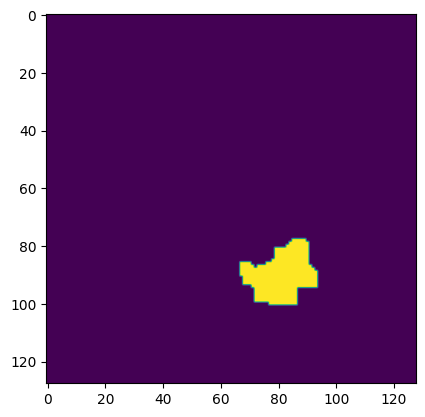

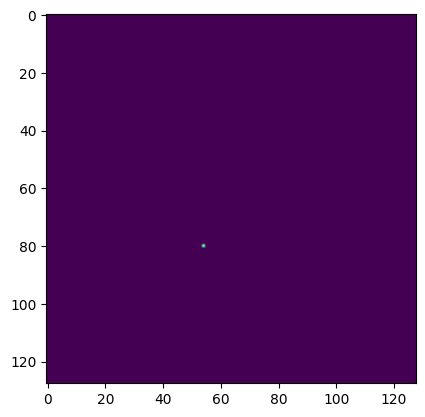

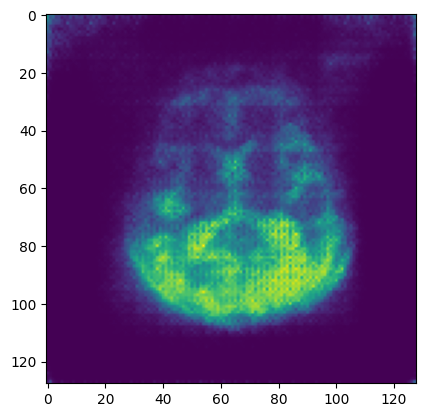

In [24]:
j= 76
plt.imshow(np.squeeze(Y_train[j,:,:,:]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[j,:,:,:]))
plt.show()
plt.imshow(np.squeeze(train_predict[j,:,:,:]))
plt.show()

**TEST DATA CAME IN:**

In [25]:
test = np.zeros((61, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)


test_path = os.path.join(path, './test/')

test_list = os.listdir(test_path)
test_list = [test_path+i for i in test_list]
test_list.sort()


In [26]:
print('Resizing mask images ')
n=0
for i in test_list:
    tst = imread(i)[:,:,:IMG_CHANNELS]
    tst = resize(tst, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    test[n] = tst  #Fill empty test with values from tst
    n += 1

Resizing mask images 


In [27]:
test_list[13]

'/content/gdrive/MyDrive/Dataset/./test/PAKE DEHI^ALI REZA_724870_49147_3_32.png'

In [28]:
test.shape

(61, 128, 128, 3)

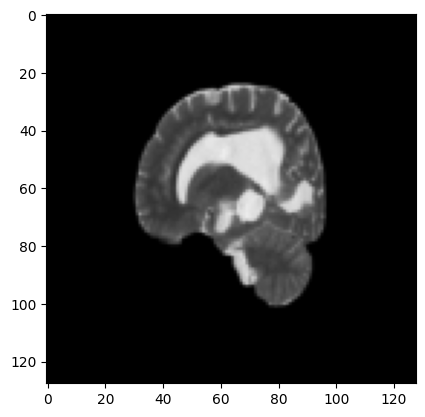

In [29]:
plt.imshow(test[60,:,:,:]);

In [30]:

test_predict = best_model.predict(test, verbose=1)
#preds_test_t = (test_predict > 0.5).astype(bool)



2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step


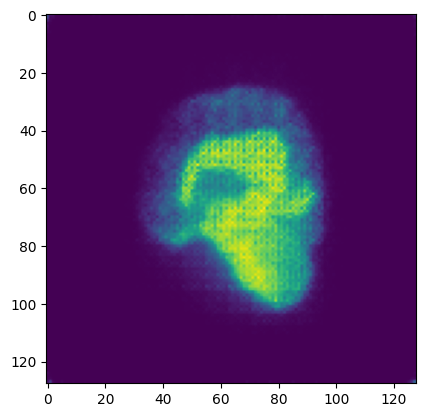

In [31]:
i=60
plt.imshow(np.squeeze(test_predict[i,:,:,:]))
plt.show()

In [43]:
import glob
TEST_PATH = '/content/gdrive/MyDrive/Dataset/test/'

# Get list of all image files in TEST_PATH
test_image_paths = glob.glob(os.path.join(TEST_PATH, '*.png'))

print(f'Found {len(test_image_paths)} test images.')

X_test = np.zeros((len(test_image_paths), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []

print('Resizing test images...')
for n, img_path in tqdm(enumerate(test_image_paths), total=len(test_image_paths)):
    img = imread(img_path)
    if img is None or img.size == 0:
        print(f'Warning: Image at {img_path} is empty or cannot be read. Skipping.')
        continue
    img = img[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')
print('X_test shape:', X_test.shape)

print('Done!')
print('X_test shape:', X_test.shape)
print('Number of test samples:', len(X_test))



idx = random.randint(0, len(X_train))


preds_train = best_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = best_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = best_model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

Found 61 test images.
Resizing test images...


100%|██████████| 61/61 [00:03<00:00, 16.06it/s]


Done!
X_test shape: (61, 128, 128, 3)
Done!
X_test shape: (61, 128, 128, 3)
Number of test samples: 61
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step


In [45]:
preds_train = best_model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = best_model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
#preds_test = model.predict(X_test, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step


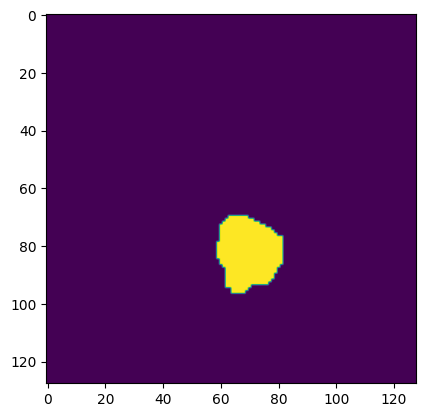

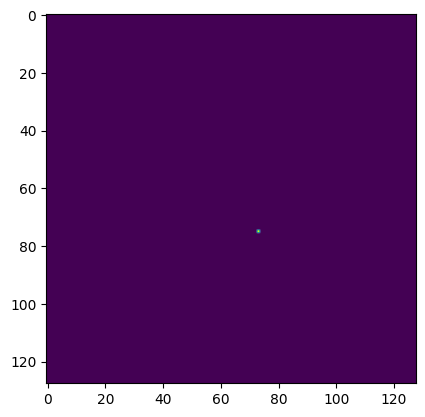

In [46]:
plt.imshow(np.squeeze(Y_train[20,:,:,:]))
plt.show()
plt.imshow(np.squeeze(preds_train_t[20,:,:,:]))

In [48]:
# Assuming the predicted_mask and ground_truth_mask are loaded as float arrays
# Step 2: Load the predicted and ground truth masks
predicted_mask = test_predict
ground_truth_mask = train_predict
predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
ground_truth_mask = (ground_truth_mask > 0.5).astype(np.uint8)
